In [1]:
import pickle as pk
import numpy as np
from glob import glob
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
_size=41

In [3]:
data_dir="../../data"
!mkdir $data_dir
#!rm $data_dir/patches*.npz
!rm $data_dir/*
!ls -lrt $data_dir/


mkdir: ../../data: File exists


In [13]:
from subprocess import Popen,PIPE
from os import system

def run(command):
    print('cmd=',command)
    system(command)
    
def runPipe(command):
    print('runPipe cmd=',command)
    p=Popen(command.split(),stdout=PIPE,stderr=PIPE)
    L=p.communicate()
    stdout=L[0].decode("utf-8").split('\n')
    stderr=L[1].decode("utf-8").split('\n')
    return stdout,stderr

def clock(message):
    print('%8.1f \t%s'%(time(),message))
    time_log.append((time(),message))

def printClock():
    t=time_log[0][0]
    for i in range(1,len(time_log)):
        print('%8.1f \t%s'%(time_log[i][0]-t,time_log[i][1]))
        t=time_log[i][0]

def list_s3_files(stack_directory):
    stdout,stderr=runPipe("aws s3 ls %s/ "%(stack_directory))
    filenames=[]
    for line in stdout:
        parts=line.strip().split()
        if len(parts)!=4:
            continue
        filenames.append(parts[-1])
    return filenames


In [14]:
s3_dir='s3://mousebraindata-open/MD657/permuted'
permuted_files=list_s3_files(s3_dir)
permuted_files[:10]

runPipe cmd= aws s3 ls s3://mousebraindata-open/MD657/permuted/ 


['permuted0.bin',
 'permuted1.bin',
 'permuted10.bin',
 'permuted11.bin',
 'permuted12.bin',
 'permuted13.bin',
 'permuted14.bin',
 'permuted15.bin',
 'permuted16.bin',
 'permuted17.bin']

In [26]:
from os.path import isfile
!touch $data_dir/tmp
!ls $data_dir
isfile(data_dir+'/tmp')

tmp


True

In [27]:
import numpy as np
from numpy import fromfile
def read_files(s3_dir,_delete=False):
    s3files=list_s3_files(s3_dir)
    for filename in s3files:
        if not isfile(data_dir+'/'+filename):
            run('aws s3 cp %s/%s %s'%(s3_dir,filename,data_dir))
        D=fromfile(data_dir+'/'+filename,dtype=np.float16)
        pics=D.reshape([-1,_size,_size])
        if _delete:
            run('rm %s/%s'%(data_dir,filename))
        yield pics


In [28]:
def data_stream():
    for pics in read_files('s3://mousebraindata-open/MD657/permuted'):
        for i in range(pics.shape[0]):
            yield pics[i,:,:]

In [34]:
!ls -lrt ../../data

total 1099264
-rw-r--r--  1 yoavfreund  staff  549058306 Oct 20 14:36 permuted0.bin
-rw-r--r--  1 yoavfreund  staff          0 Oct 21 09:37 tmp


In [64]:
pics_list=[]
i=0
for pic in data_stream():
    pics_list.append(np.array(pic,dtype=np.float32))
    i+=1
    if i>=300000:
        break

    
    

runPipe cmd= aws s3 ls s3://mousebraindata-open/MD657/permuted/ 
cmd= aws s3 cp s3://mousebraindata-open/MD657/permuted/permuted1.bin ../../data


In [65]:
import matplotlib.pyplot as plt
from astropy.convolution import Gaussian2DKernel,convolve
gaussian = Gaussian2DKernel(1,x_size=7,y_size=7)
factor=sum(gaussian)
print('factor=',factor)
def calc_err(pic):
    P=convolve(pic,gaussian)/factor
    error=sqrt(mean(abs(pic-P)))
    sub=P[::2,::2]
    return error,sub

factor= 0.9994587918263369


In [66]:
def plot_patches(data,h=40,w=15,_titles=[]):
    figure(figsize=(w*2,h*2))
    for i in range(h*w):
        if i>=data.shape[0]:
            break
        subplot(h,w,i+1);
        pic=data[i,:,:]
        #P=convolve(pic,gaussian)/factor

        fig=imshow(pic,cmap='gray')
        if(len(_titles)>i):
            plt.title(_titles[i])
        fig.axes.get_xaxis().set_visible(False)
        fig.axes.get_yaxis().set_visible(False)
#plot_patches(scombined,h=2,_titles=[str(i) for i in range(scombined.shape[0])])

In [67]:
def pack_pics(Reps):
    size=Reps[0].shape[0]
    _len=len(Reps)
    Reps_mat=np.zeros([_len,size,size])
    for i in range(_len):
        Reps_mat[i,:,:]=Reps[i]
    return Reps_mat

In [68]:
pics=pack_pics(pics_list)

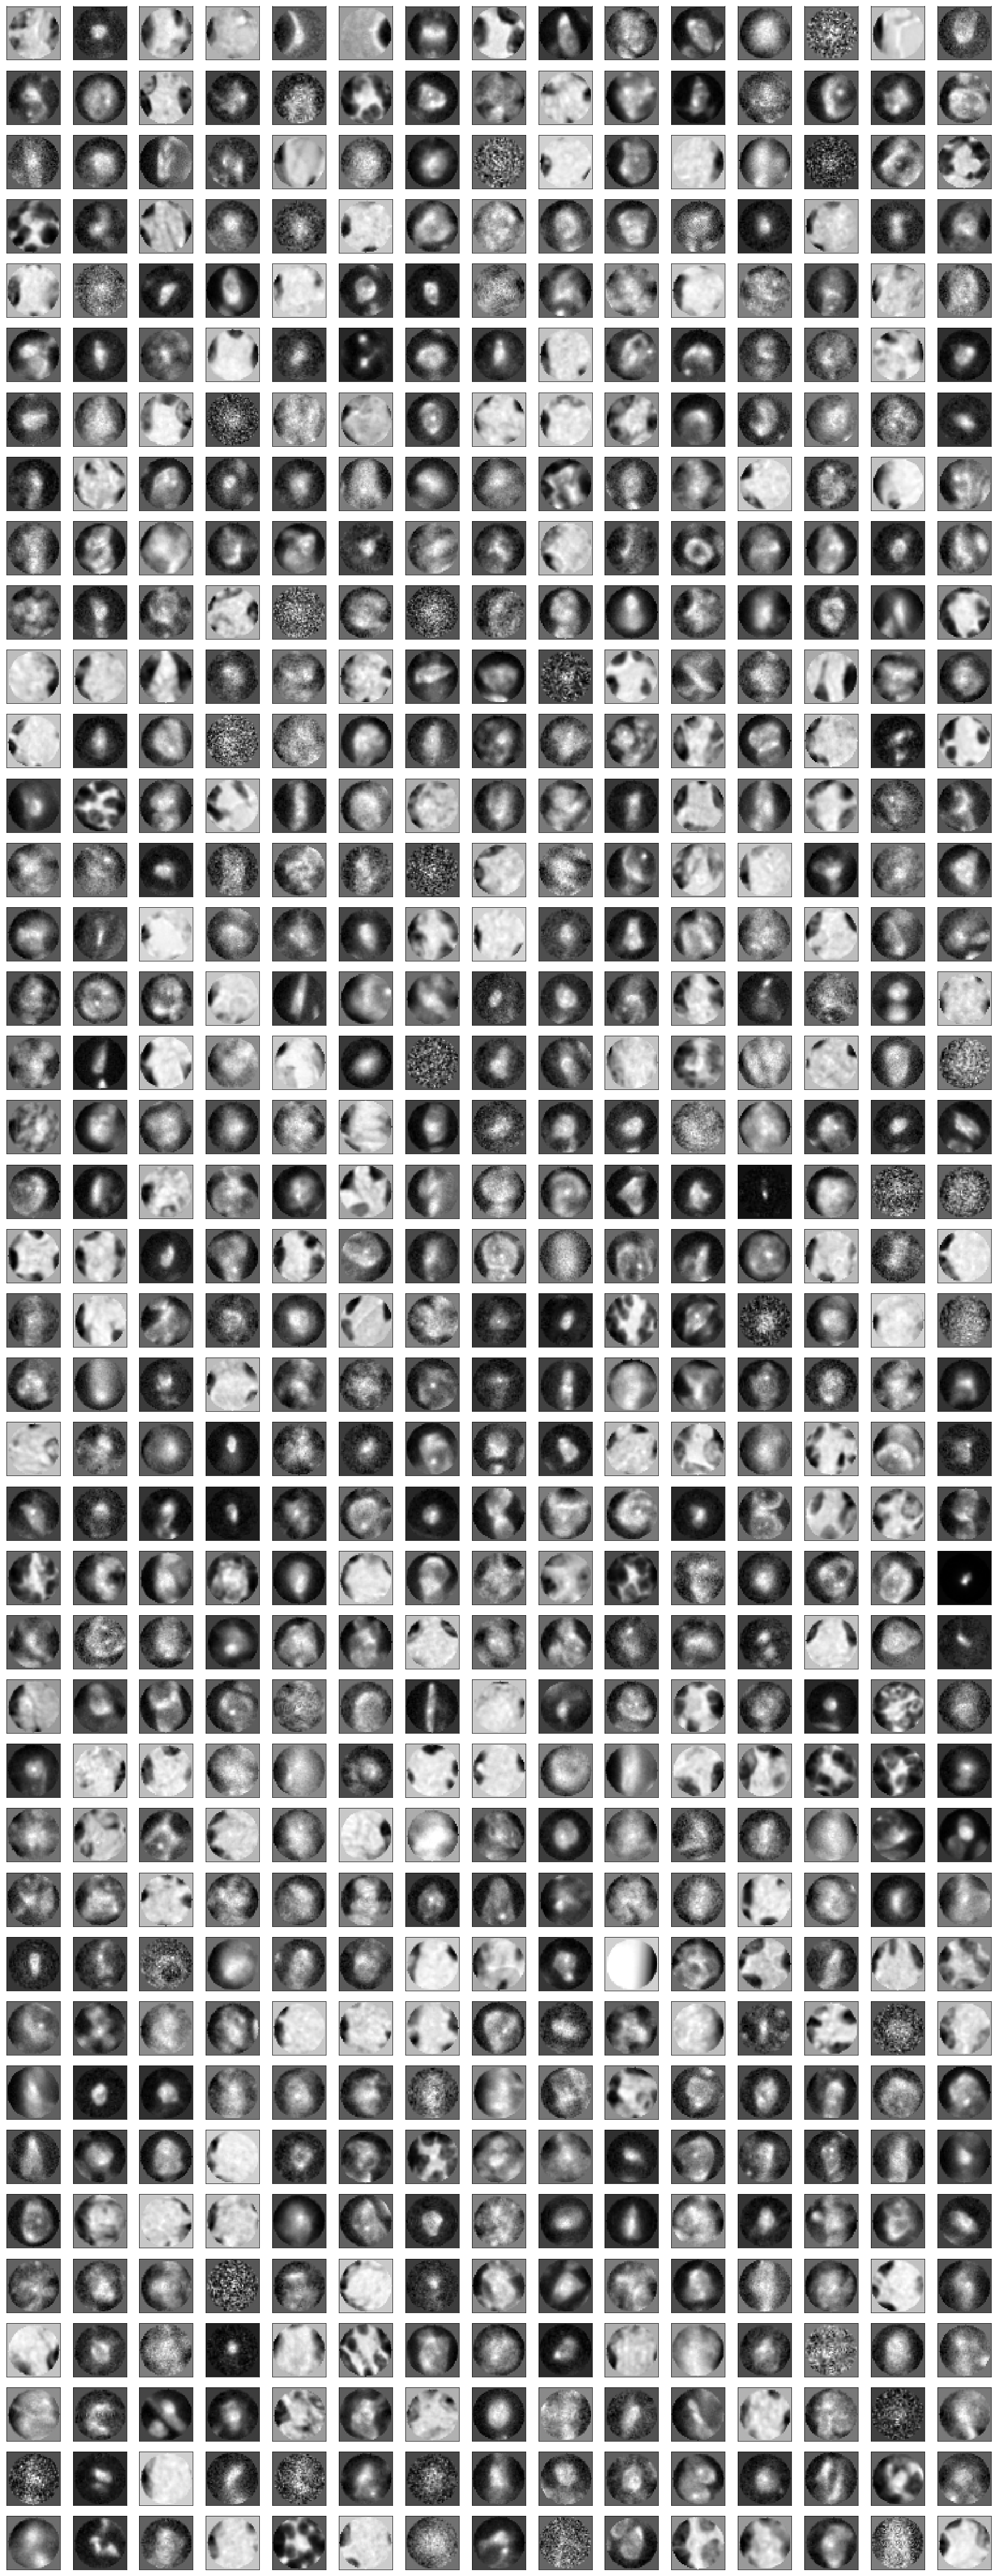

In [69]:
plot_patches(pics)

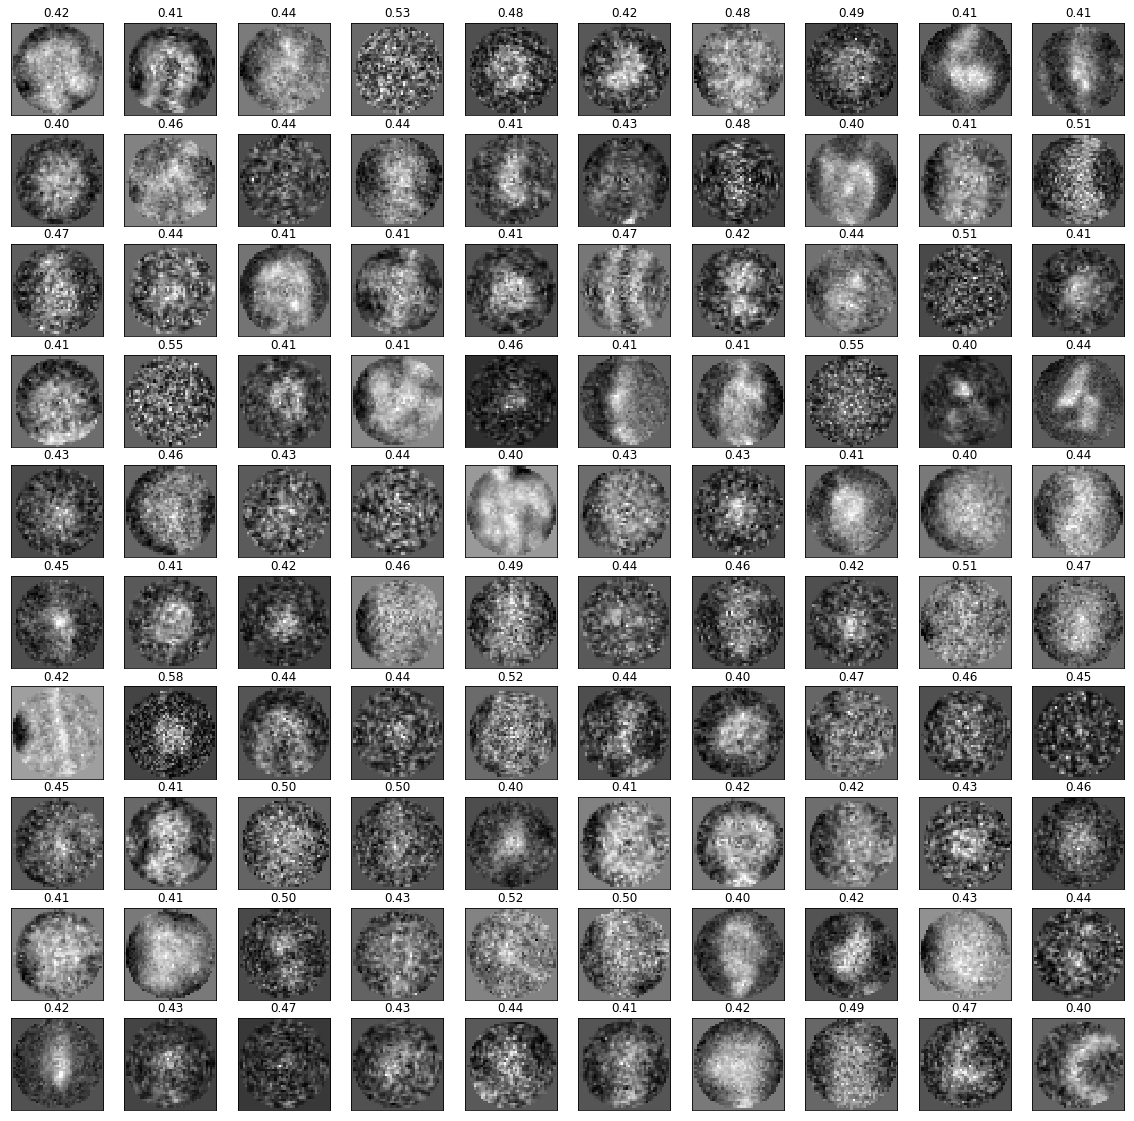

In [70]:
shift=1000
selected=[]
errors=[]
i=0; j=0;
while j < 100:
    pic=pics[i+shift,:,:]
    i+=1
    error,sub=calc_err(pic)
    if error<0.4:
        continue
    j+=1
    selected.append(pic)
    errors.append('%4.2f'%error)
plot_patches(pack_pics(selected),h=10,w=10,_titles=errors)

In [71]:
#collect images that are pretty smooth
# reduce resolution by a factor of 2
low_err=[]
for i in range(pics.shape[0]):
    pic=pics[i,:,:]
    error,sub=calc_err(pic)
    if error<0.4:
        low_err.append(sub)
        j=len(low_err)
        if j%1000==0:
            print('\r',i,j,end='')

lcombined=np.stack(low_err)
lcombined.shape

 299235 280000

(280717, 21, 21)

In [72]:
lcombined.shape

(280717, 21, 21)

In [73]:
def dist2(a,b):
    diff=(a-b)**2
    return sum(diff.flatten())

In [74]:
D=[]
for i in range(1,lcombined.shape[0]):
    D.append(dist2(lcombined[i,:,:],lcombined[i-1,:,:]))
    if i%1000==0:
        print('\r',i,end='')

 280000

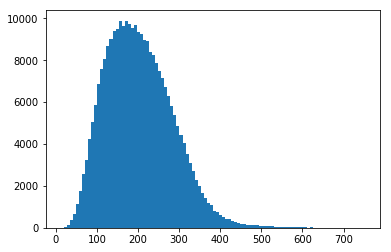

In [75]:
hist(D,bins=100);

In [76]:
max(D)

752.4057915094176

In [77]:
def refineKmeans(data,Reps):
    new_Reps=[np.zeros(Reps[0].shape) for r in Reps]
    Reps_count=[0.0 for r in Reps]
    error=0
    for i in range(data.shape[0]): 
        patch=data[i,:,:]
        dists=[dist2(patch,r) for r in Reps]
        _argmin=argmin(dists)
        _min=min(dists)
        new_Reps[_argmin]+=patch
        Reps_count[_argmin]+=1
        error+=_min
    error /= data.shape[0]
    final_Reps=[]
    final_counts=[]
    for i in range(len(new_Reps)):
        if Reps_count[i]>5:
            final_Reps.append(new_Reps[i]/Reps_count[i])
            final_counts.append(Reps_count[i])
    return final_Reps,final_counts,error

In [78]:
def Kmeans(data,n=100,scale=550):
    Reps,Statistics = Kmeanspp(data,n,scale)
    for i in range(5):
        Reps,error = refineKmeans(data,Reps)
        print('refine iteration %2d, error=%7.3f'%(i,error))

In [79]:
def Kmeanspp(data,n=100,scale=550):
    Reps=[data[0,:,:]]

    Statistics=[]
    j=1
    for i in range(1,data.shape[0]): 
        _min=100000
        patch=data[i,:,:]
        for r in Reps:
            _min=min(_min,dist2(patch,r))
        Prob=_min/scale
        print('\r','i=%10d,  #reps=%10d  Prob=%8.6f'%(i,len(Reps),Prob),end='')
        Statistics.append((i,len(Reps),_min))
        if np.random.rand()<Prob:
            Reps.append(patch)
            j+=1
        if j>=n:
            break
    return Reps,Statistics

In [80]:
def plot_statistics(Statistics,alpha=0.05,_start=10): 
    N=[x[1] for x in Statistics]
    d=[x[2] for x in Statistics]

    s=mean(d[:_start])
    smoothed=[s]*_start
    for x in d[_start:]:
        s=(1-alpha)*s + alpha*x
        smoothed.append(s)
    loglog(N[_start:],smoothed[_start:])
    xlabel('N')
    ylabel('smoothed distance')
    grid(which='both')

 i=      2074,  #reps=       299  Prob=0.259001

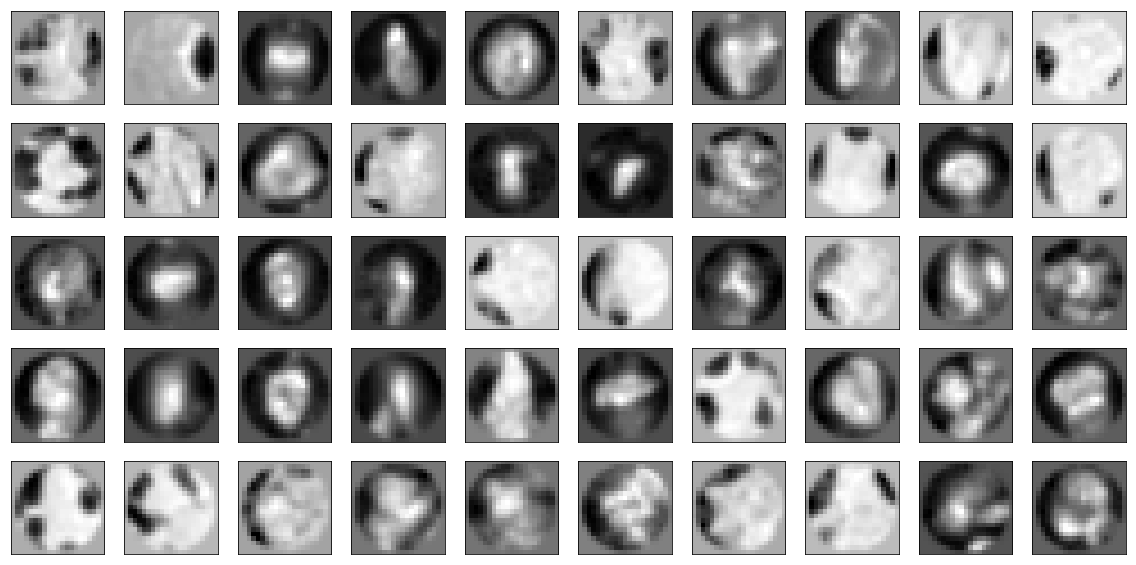

In [81]:
N=300

Reps, Statistics = Kmeanspp(lcombined,n=N)
Reps_mat = pack_pics(Reps)
plot_patches(Reps_mat,h=5,w=10)

In [82]:
Reps_mat.shape

(300, 21, 21)

1 70.1270590016151 250
2 52.11751208732854 249
3 51.08191933162851 249


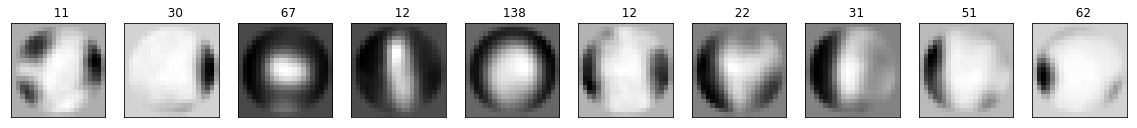

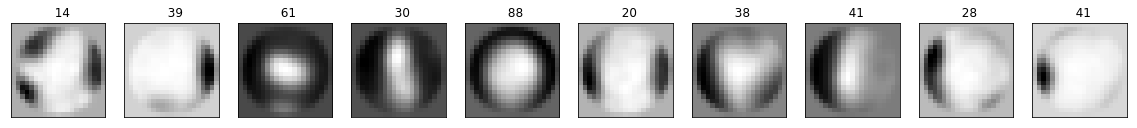

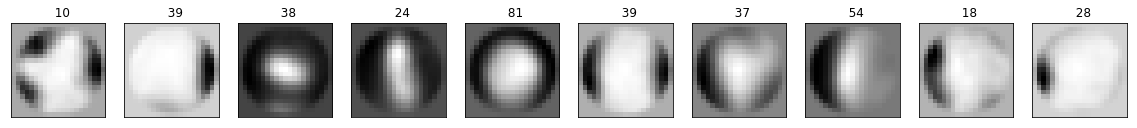

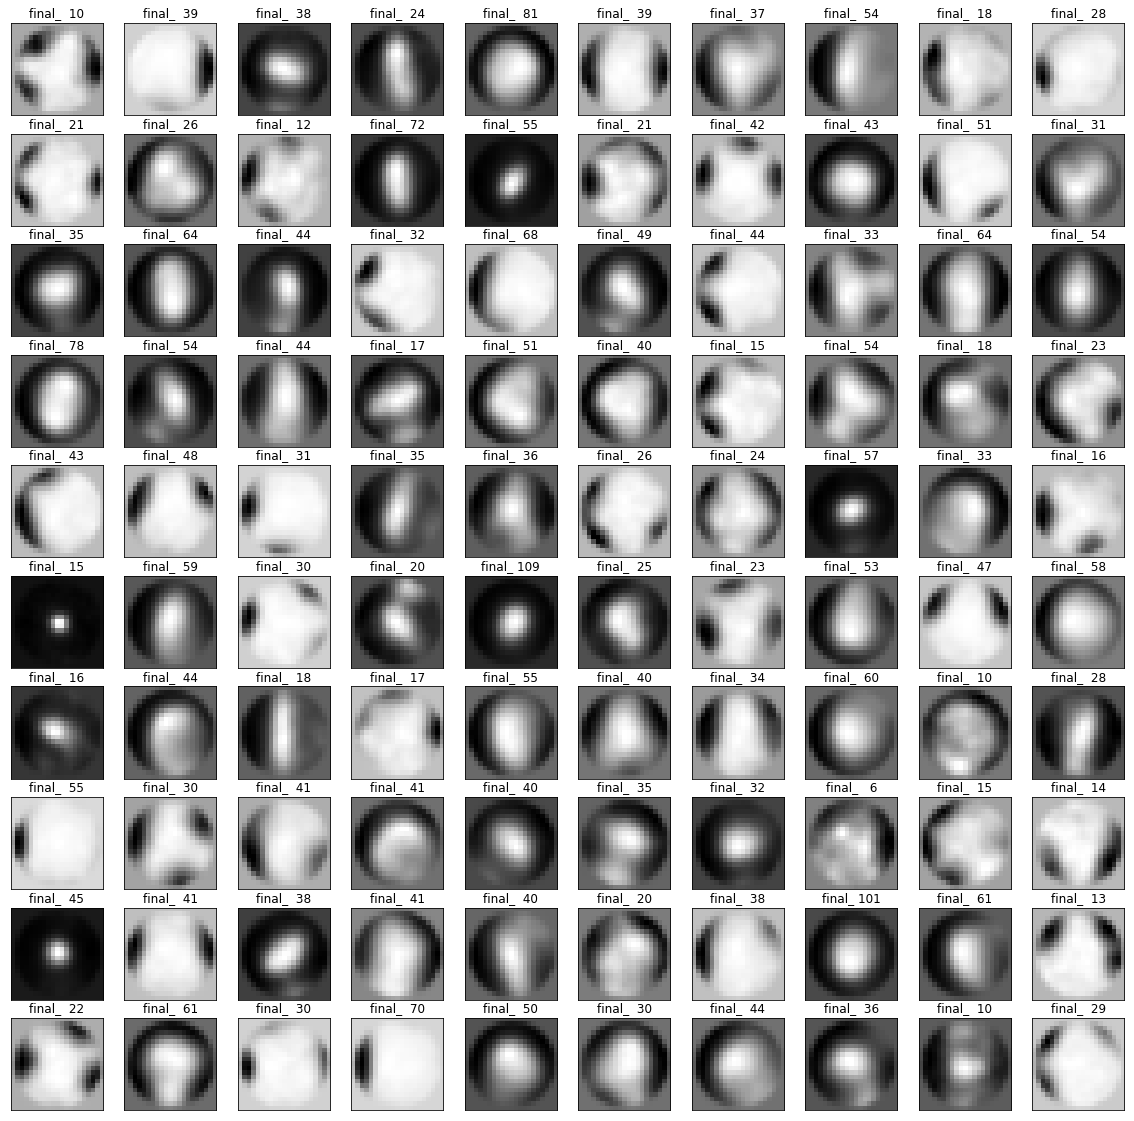

In [83]:
for i in range(1,4):
    new_Reps,Reps_count,error = refineKmeans(lcombined[i*10000:(i+1)*10000,:,:],Reps)
    print(i,error,len(Reps_count))
    Reps_mat = pack_pics(new_Reps)
    plot_patches(Reps_mat,h=1,w=10,_titles=['%4d'%x for x in Reps_count])
    Reps=new_Reps
plot_patches(Reps_mat,h=10,w=10,_titles=['final_%4d'%x for x in Reps_count])

## Calculate laplacian random-walk matrix

The matrix corresponds to a simple random walk on the individual examples  where the location of each example is replaced by the location of the corresponding representative. 

We use [pydiffmap](https://pydiffmap.readthedocs.io/en/master/)

In [84]:
L=len(new_Reps)
new_Reps[0].shape
data1D=np.concatenate([x.reshape([1,441]) for x in new_Reps])
data1D.shape

(249, 441)

Text(0.5,1,'distances between centroids')

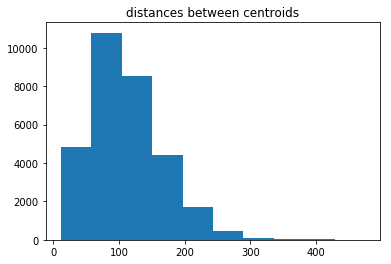

In [85]:
dists=[]
for i in range(L):
    for j in range(i):
        dists.append(dist2(new_Reps[i],new_Reps[j]))
hist(dists);
title('distances between centroids')

In [ ]:
!sudo pip3 install pydiffmap

In [86]:
data1D.shape,len(Reps_count)

((249, 441), 249)

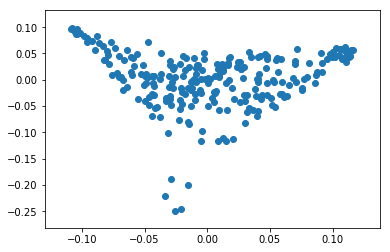

In [87]:
from pydiffmap import diffusion_map as dm
# initialize Diffusion map object.
neighbor_params = {'n_jobs': -1, 'algorithm': 'ball_tree'}

mydmap = dm.DiffusionMap(n_evecs=50, k=20, epsilon=100.0, alpha=1.0, neighbor_params=neighbor_params)
# fit to data and return the diffusion map.
dmap = mydmap.fit_transform(data1D,weights=Reps_count)

#%pylab inline
pylab.scatter(dmap[:,0],dmap[:,1]);

Text(0.5,1,'no. of examples per partition')

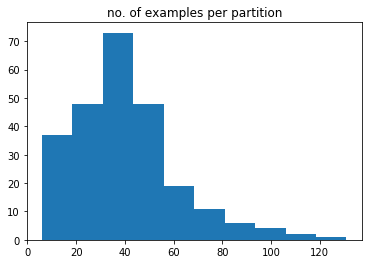

In [88]:
hist(Reps_count);
title('no. of examples per partition')

In [89]:
image_size=np.array(new_Reps[0].shape)
canvas_size=np.array([1000,1000])
_minx=min(dmap[:,0])
_maxx=max(dmap[:,0])
_miny=min(dmap[:,1])
_maxy=max(dmap[:,1])
shift_x = -_minx
scale_x = canvas_size[0]/(_maxx - _minx)
shift_y = -_miny
scale_y = canvas_size[1]/(_maxy - _miny)

x=[int((_x+shift_x)*scale_x) for _x in dmap[:,0]]
y=[int((_y+shift_y)*scale_y) for _y in dmap[:,1]]

canvas=2*np.ones(canvas_size+image_size)
for i in range(len(new_Reps)):
    if(Reps_count[i]>30):
        canvas[x[i]:x[i]+image_size[0],y[i]:y[i]+image_size[1]]=new_Reps[i]

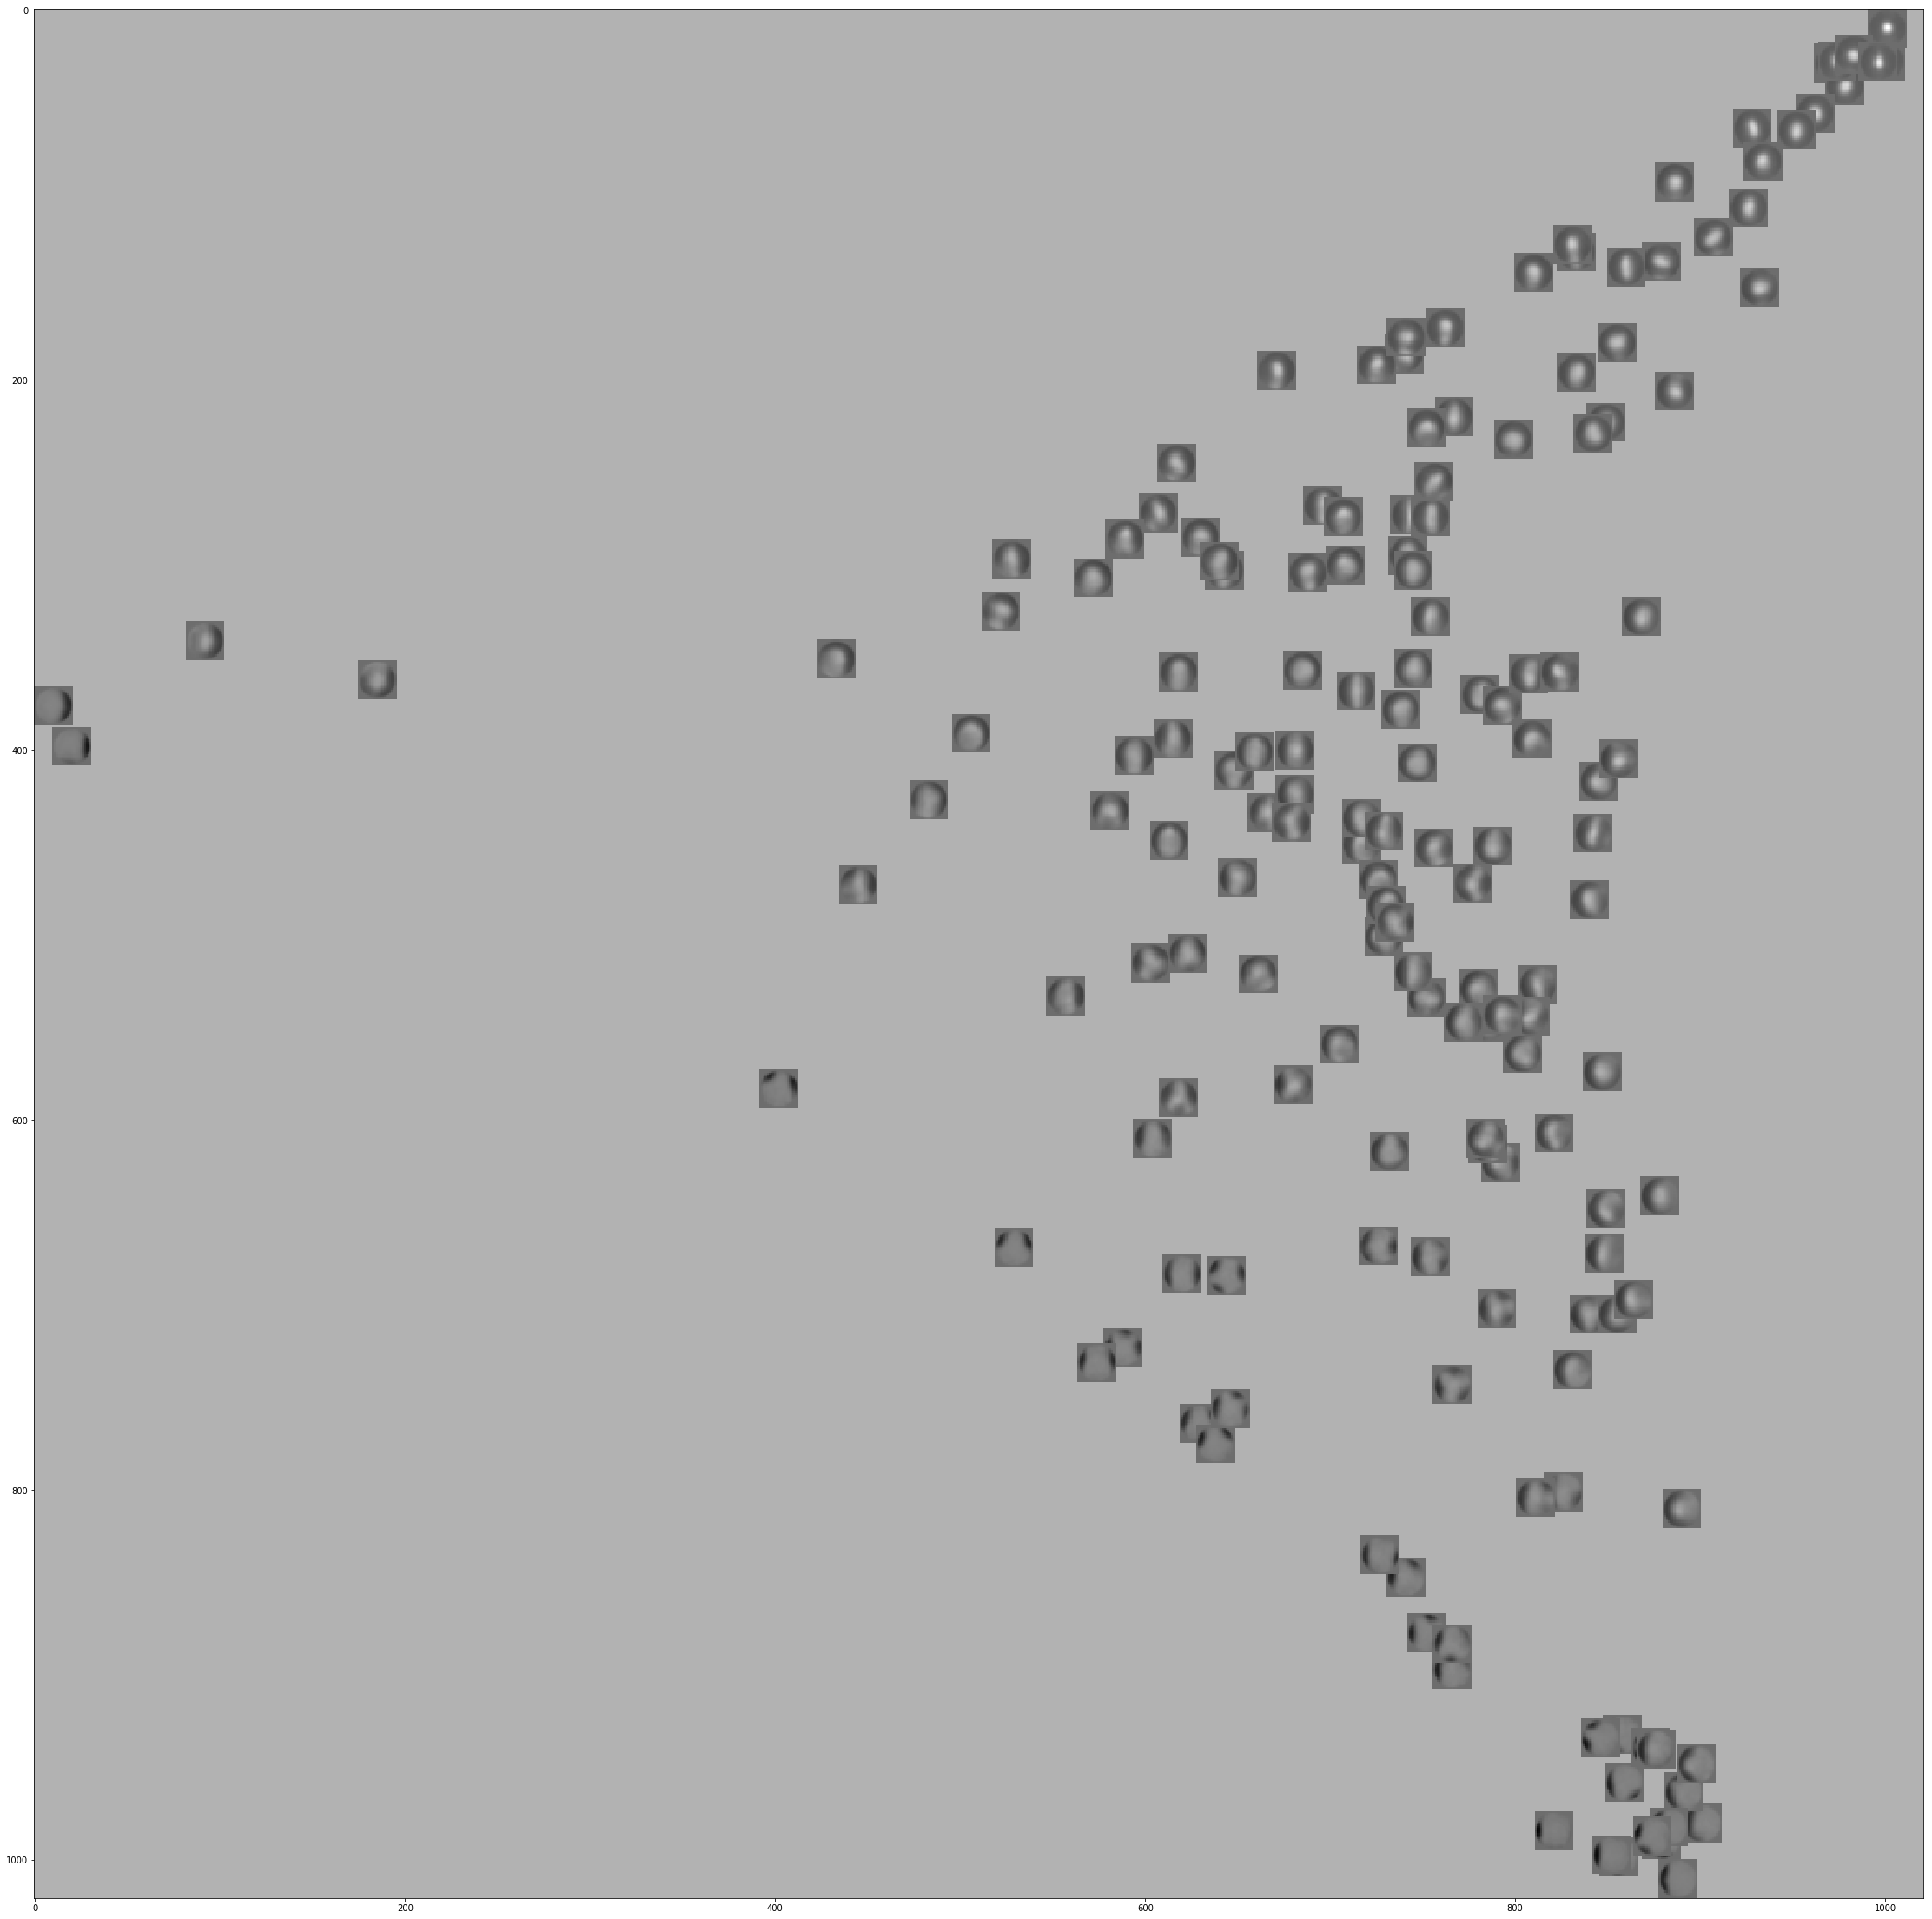

In [90]:
figure(figsize=[40,40])
imshow(canvas,cmap='gray')

In [ ]:
max(new_Reps[0].flatten())

In [ ]:
from pydiffmap.visualization import embedding_plot, data_plot

embedding_plot(mydmap, scatter_kwargs = {'c': dmap[:,0], 'cmap': 'Spectral'})
data_plot(mydmap, dim=3, scatter_kwargs = {'cmap': 'Spectral'})

plt.show()

In [ ]:
A=np.zeros([L,L])
for i in range(L):
    for j in range(L):
        w=exp(-dist2(new_Reps[i],new_Reps[j])/sigma2)
        A[i,j]=w * Reps_count[i]*Reps_count[j]

In [ ]:
D=sum(A,axis=0)
D2=diag(1/sqrt(D))

NA=np.dot(D2,np.dot(A,D2))

w,v = np.linalg.eig(NA)
hist(NA.flatten(),bins=100);

In [ ]:
i=0
print('eig no %3d eigval=%5.3f'%(i,w[i]))
sorted_v=sort(v[i,:])
order=argsort(v[i,:])
plot_patches(Reps_mat[order],h=10,w=10,_titles=['c_%1d=%6.3f'%(i,x) for x in sorted_v])

In [ ]:
plot(w[:10])

In [ ]:
scatter(v[1,:],v[2,:])

In [ ]:
v[2,:]